In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('./Data',
                                                    labels='inferred',
                                                    batch_size=32, 
                                                    image_size=(256,256),
                                                    shuffle=True)

Found 4062 files belonging to 4 classes.


In [6]:
print(dataset)
len(dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


127

In [4]:
class_names = dataset.class_names
class_names

['Black_Measles', 'Black_Rot', 'Healthy', 'Leaf_Blight']

In [5]:
for image_batchs, image_labels in dataset.take(1):
    print(image_batchs.shape)
#     print(image_batchs.numpy())
    print(image_labels.numpy())

(32, 256, 256, 3)
[2 1 1 1 3 1 0 1 0 1 0 3 3 3 3 1 0 1 1 0 0 1 1 0 1 3 0 1 1 0 2 0]


In [7]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset,127)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

101
12
14


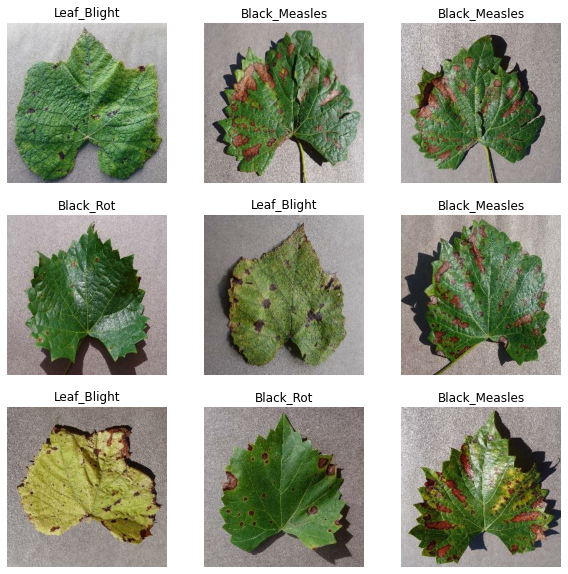

In [9]:
plt.figure(figsize=(10,10))
for image_batchs, image_labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.axis('off')
        plt.imshow(image_batchs[i].numpy().astype("uint8"))
        plt.title(class_names[image_labels[i].numpy()])

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', 
    input_shape=(256,256,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(.5, .2)
])

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
run_logdir = './runs/run_1/'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(run_logdir+"CNN_1.h5", save_best_only=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [20]:
history = model.fit(
  train_ds, 
  validation_data = val_ds, 
  epochs=50,
  callbacks=[checkpoint_cb, tensorboard_cb]
)

Epoch 1/50
101/101 [==============================] - 62s 360ms/step - loss: 1.1849 - accuracy: 0.4130 - val_loss: 0.9640 - val_accuracy: 0.5286
Epoch 2/50
101/101 [==============================] - 26s 260ms/step - loss: 0.7594 - accuracy: 0.6601 - val_loss: 0.6452 - val_accuracy: 0.7135
Epoch 3/50
101/101 [==============================] - 24s 234ms/step - loss: 0.5572 - accuracy: 0.7988 - val_loss: 0.5482 - val_accuracy: 0.8177
Epoch 4/50
101/101 [==============================] - 24s 234ms/step - loss: 0.4966 - accuracy: 0.8204 - val_loss: 0.4040 - val_accuracy: 0.8516
Epoch 5/50
101/101 [==============================] - 24s 236ms/step - loss: 0.3626 - accuracy: 0.8687 - val_loss: 0.3357 - val_accuracy: 0.8880
Epoch 6/50
101/101 [==============================] - 24s 241ms/step - loss: 0.3467 - accuracy: 0.8805 - val_loss: 0.2288 - val_accuracy: 0.9245
Epoch 7/50
101/101 [==============================] - 25s 248ms/step - loss: 0.2394 - accuracy: 0.9189 - val_loss: 0.3756 - val_ac

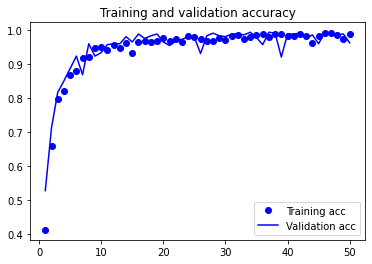

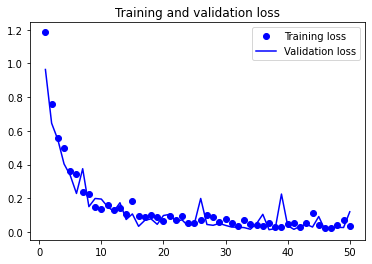

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
scores = model.evaluate(test_ds)
scores

14/14 [==============================] - 1s 48ms/step - loss: 0.1542 - accuracy: 0.9621


[0.15420004725456238, 0.9620535969734192]

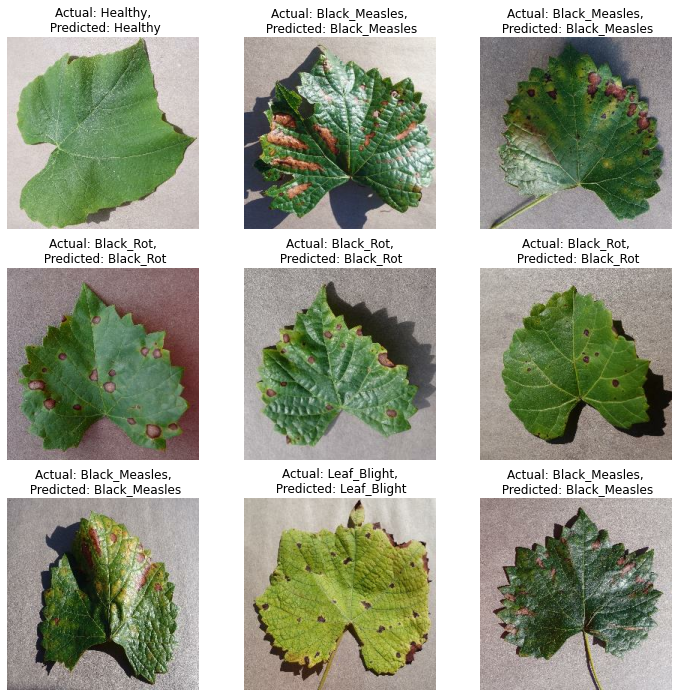

In [26]:
plt.figure(figsize=(12, 12))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images_batch[i].numpy().astype('uint8'))
        
        batch_prediction = model.predict(images_batch)
        
        plt.title(f"Actual: {class_names[labels_batch[i].numpy()]},\n Predicted: {class_names[np.argmax(batch_prediction[i])]}")

        plt.axis("off")

In [27]:
labels_batch.numpy()

array([2, 0, 0, 1, 1, 1, 0, 3, 0, 1, 3, 3, 3, 0, 0, 1, 0, 1, 1, 2, 0, 3,
       0, 3, 3, 2, 1, 0, 0, 1, 1, 3])

In [29]:
batch_prediction.shape

(32, 4)

In [34]:
labels_batch_prediction = [np.argmax(x) for x in batch_prediction]
# labels_batch_prediction

[2,
 0,
 0,
 1,
 1,
 1,
 0,
 3,
 0,
 1,
 3,
 3,
 3,
 0,
 0,
 1,
 0,
 1,
 3,
 2,
 0,
 3,
 0,
 3,
 3,
 2,
 0,
 0,
 0,
 1,
 1,
 3]

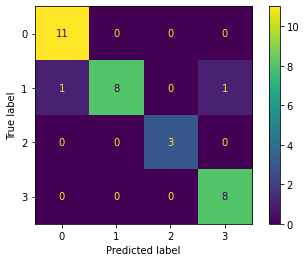

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = confusion_matrix(labels_batch.numpy(), labels_batch_prediction)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()